In [ ]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import scipy
from itertools import combinations
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
LD = pd.read_csv("/content/gdrive/My Drive/COMP 565/LD.csv", compression='gzip')
LD = LD.drop("Unnamed: 0", axis = 1)
LD.index = LD.columns
LD.values[[np.arange(LD.shape[0])]*2] = 1

<ipython-input-3-2df919d7d22a>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  LD.values[[np.arange(LD.shape[0])]*2] = 1


In [ ]:
zscore = pd.read_csv("/content/gdrive/My Drive/COMP 565/zscore.csv", compression='gzip')
zscore.columns = ["SNP", "zscore"]

In [ ]:
SNP_pip = pd.read_csv("/content/gdrive/My Drive/COMP 565/SNP_pip.csv", compression='gzip')
SNP_pip = SNP_pip["x"]

# Part 1

When k = 1, meaning that there is one causal SNP

In [ ]:
snp1z = list(combinations(LD.columns, 1))
snp1 = []
for i in range(len(snp1z)):
  s = snp1z[i][0]
  snp1.append(s)
snp1 = pd.DataFrame(snp1)
snp1.columns = ["SNP1"]

When k = 2, meaning that there are two causal SNPs

In [ ]:
snp2z = list(combinations(LD.columns, 2))
snp2 = []
for i in range(len(snp2z)):
  s1 = snp2z[i][0]
  s2 = snp2z[i][1]
  snp2.append([s1,s2])
snp2 = pd.DataFrame(snp2)
snp2.columns = ["SNP1", "SNP2"]

When k = 3, meaning that there are three causal SNPs

In [ ]:
snp3z = list(combinations(LD.columns, 3))
snp3 = []
for i in range(len(snp3z)):
  s1 = snp3z[i][0]
  s2 = snp3z[i][1]
  s3 = snp3z[i][2]
  snp3.append([s1,s2, s3])
snp3 = pd.DataFrame(snp3)
snp3.columns = ["SNP1", "SNP2", "SNP3"]

Define the function to compute bayes factor

In [ ]:
def bayes_factor(k = 1):
  if k == 1:
    BF1 = []
    for i in range(len(snp1)):
      s1 = snp1.iloc[i,0]
      z1 = zscore[zscore["SNP"] == s1]["zscore"].to_numpy()
      r_cc = LD[s1].loc[snp1.iloc[i]].to_numpy()
      sigma_cc = 2.49 * np.identity(1)
      means = np.zeros(1)
      cov_num = r_cc + np.matmul(r_cc, np.matmul(sigma_cc, r_cc))

      numerator = multivariate_normal.pdf(z1, mean=means, cov=cov_num)
      denominator = multivariate_normal.pdf(z1, mean = means, cov=r_cc)

      bf1 = numerator / denominator
      BF1.append(bf1)

    return BF1

  elif k == 2:
    BF2 = []
    for i in range(len(snp2)):
      s1 = snp2.iloc[i,0]
      s2 = snp2.iloc[i,1]
      z2 = zscore[zscore["SNP"].isin([s1,s2])]["zscore"].to_numpy()
      r_cc = LD[[s1,s2]].loc[snp2.iloc[i]].to_numpy()
      sigma_cc = 2.49 * np.identity(2)
      means = np.zeros(2)
      cov_num = r_cc + np.matmul(r_cc, np.matmul(sigma_cc, r_cc))
      cov_num = cov_num.astype('float64')

      # Avoid singular matrix
      if np.linalg.det(cov_num) < 1e-8:
        BF2.append(1e30)
      else:

        numerator = multivariate_normal.pdf(z2, mean=means, cov=cov_num)
        denominator = multivariate_normal.pdf(z2, mean=means, cov=r_cc)

        bf2 = numerator / denominator
        BF2.append(bf2)
    
    return BF2

  elif k==3:
    BF3 = []
    for i in range(len(snp3)):
      s1 = snp3.iloc[i, 0]
      s2 = snp3.iloc[i, 1]
      s3 = snp3.iloc[i, 2]
      z3 = zscore[zscore["SNP"].isin([s1,s2,s3])]["zscore"].to_numpy()
      r_cc = LD[[s1,s2,s3]].loc[snp3.iloc[i]].to_numpy()
      sigma_cc = 2.49 * np.identity(3)
      means = np.zeros(3)
      cov_num = r_cc + np.matmul(r_cc, np.matmul(sigma_cc, r_cc))
      cov_num = cov_num.astype('float64')

      # Avoid singular matrix
      if np.linalg.det(cov_num) < 1e-8:
        BF3.append(1e30)
      else:
        numerator = multivariate_normal.pdf(z3, mean=means, cov=cov_num)
        denominator = multivariate_normal.pdf(z3, mean=means, cov=r_cc)

        bf3 = numerator / denominator
        BF3.append(bf3)
    return BF3


In [ ]:
snp1["BF1"] = bayes_factor(k=1)
snp2["BF2"]=bayes_factor(k=2)
snp3["BF3"]=bayes_factor(k=3)

# Part 2

In [ ]:
def prior(m=100, k=1):
  p = (1/m)**k * ((m-1)/m)**(m-k)
  return p


In [ ]:
prior1 = prior(k=1)
snp1["prior1"] = prior1

In [ ]:
prior2 = prior(k=2)
snp2["prior2"] = prior2

In [ ]:
prior3 = prior(k=3)
snp3["prior3"] = prior3

# Part 3

In [ ]:
bf_pr1 = snp1["BF1"] * snp1["prior1"]
bf_pr2 = snp2["BF2"] * snp2["prior2"]
bf_pr3 = snp3["BF3"] * snp3["prior3"]
sum_of_bfpr = bf_pr1.sum() + bf_pr2.sum() + bf_pr3.sum()

In [ ]:
posterior1 = bf_pr1 / sum_of_bfpr
posterior2 = bf_pr2 / sum_of_bfpr
posterior3 = bf_pr3 / sum_of_bfpr

In [ ]:
snp1["posterior"] = posterior1
snp2["posterior"] = posterior2
snp3["posterior"] = posterior3

In [ ]:
snp1.insert(1, "SNP2", np.nan)
snp1.insert(2, "SNP3", np.nan)
snp1 = snp1.rename({"BF1": "BF", "prior1": "prior"}, axis = 1)

snp2.insert(2, "SNP3", np.nan)
snp2 = snp2.rename({"BF2": "BF", "prior2": "prior"}, axis = 1)

snp3 = snp3.rename({"BF3": "BF", "prior3": "prior"}, axis = 1)

In [ ]:
SNP = pd.concat([snp1, snp2, snp3]).reset_index()
SNP = SNP.drop("index", axis = 1)

In [ ]:
SNP_sorted = SNP.sort_values(by = ['posterior'])
SNP_sorted = SNP_sorted.reset_index()
del SNP_sorted["index"]
SNP_sorted["sorted_configuration"] = SNP_sorted.index

In [62]:
SNP

,SNP1,SNP2,SNP3,BF,prior,posterior
0,rs1387412,NaN,NaN,1.309173e+01,3.697296e-03,4.090088e-37
1,rs1489360,NaN,NaN,1.109749e+00,3.697296e-03,3.467052e-38
2,rs11774323,NaN,NaN,1.374610e+01,3.697296e-03,4.294525e-37
3,rs16881260,NaN,NaN,1.109749e+00,3.697296e-03,3.467052e-38
4,rs7009162,NaN,NaN,1.046314e+00,3.697296e-03,3.268870e-38
...,...,...,...,...,...,...
166745,rs4588886,rs4288405,rs4876333,2.097507e+19,3.772366e-07,6.686033e-23
166746,rs10102107,rs10110311,rs4288405,2.703662e+34,3.772366e-07,8.618220e-08
166747,rs10102107,rs10110311,rs4876333,9.210530e+34,3.772366e-07,2.935957e-07
166748,rs10102107,rs4288405,rs4876333,4.061876e+31,3.772366e-07,1.294768e-10


In [61]:
SNP_sorted

,SNP1,SNP2,SNP3,BF,prior,posterior,sorted_configuration
0,rs6996166,rs6469329,rs10955554,6.769315e-01,3.772366e-07,2.157793e-42,0
1,rs6996166,rs6469329,rs1489354,6.769315e-01,3.772366e-07,2.157793e-42,1
2,rs6996166,rs6469329,rs7388644,6.769315e-01,3.772366e-07,2.157793e-42,2
3,rs6996166,rs6469329,rs4448249,6.769315e-01,3.772366e-07,2.157793e-42,3
4,rs6996166,rs6469329,rs1546013,6.769315e-01,3.772366e-07,2.157793e-42,4
...,...,...,...,...,...,...,...
166745,rs16881787,rs10104559,rs10102107,1.887874e+40,3.772366e-07,6.017805e-02,166745
166746,rs13250058,rs12675941,rs10102107,2.219958e+40,3.772366e-07,7.076358e-02,166746
166747,rs13250058,rs12675941,rs10104559,2.471895e+40,3.772366e-07,7.879436e-02,166747
166748,rs12678842,rs10104559,rs10102107,2.791995e+40,3.772366e-07,8.899790e-02,166748


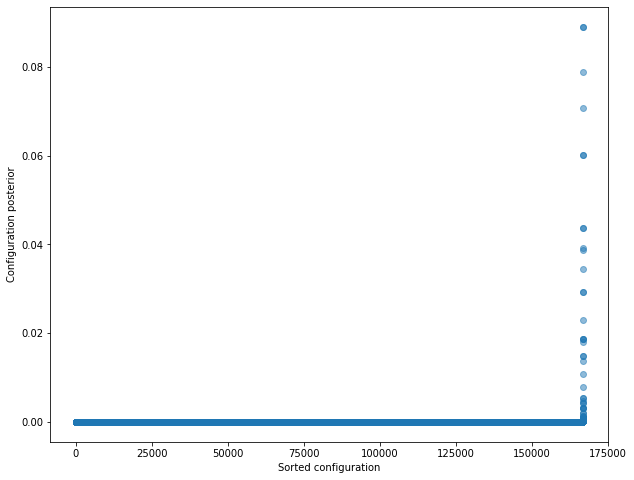

In [ ]:
plt.figure(figsize = (10,8))
plt.scatter(x = SNP_sorted["sorted_configuration"], y = SNP_sorted["posterior"], alpha = 0.5)
plt.xlabel('Sorted configuration')
plt.ylabel('Configuration posterior')
plt.show()

# Part 4

In [ ]:
def PIP_snp():
  PIP = []
  sum_of_all_scores = SNP_sorted["posterior"].sum()
  snps = LD.columns.to_numpy()

  for snp in snps:
    sum_snp_scores = (SNP_sorted[SNP_sorted["SNP1"] == snp]["posterior"].sum() + 
                      SNP_sorted[SNP_sorted["SNP2"] == snp]["posterior"].sum() + 
                      SNP_sorted[SNP_sorted["SNP3"] == snp]["posterior"].sum())
    pip = sum_snp_scores / sum_of_all_scores
    PIP.append([snp, pip])
  
  return PIP

In [ ]:
inferred_PIP = pd.DataFrame(PIP_snp())
inferred_PIP.columns = ["SNP", "PIP"]

In [ ]:
inferred_PIP

,SNP,PIP
0,rs1387412,0.000109
1,rs1489360,0.000091
2,rs11774323,0.000107
3,rs16881260,0.000091
4,rs7009162,0.000094
...,...,...
95,rs4588886,0.001352
96,rs10102107,0.568810
97,rs10110311,0.328959
98,rs4288405,0.000762


In [ ]:
SNP_pip

0     0.000103
1     0.000086
2     0.000102
3     0.000086
4     0.000089
        ...   
95    0.001302
96    0.569810
97    0.330284
98    0.000734
99    0.005776
Name: x, Length: 100, dtype: float64

Create the scatter plot

In [ ]:
PIP = inferred_PIP.copy()
p_value = scipy.stats.norm.sf(abs(zscore["zscore"]))
PIP["-log10(p)"] = - np.log10(p_value)

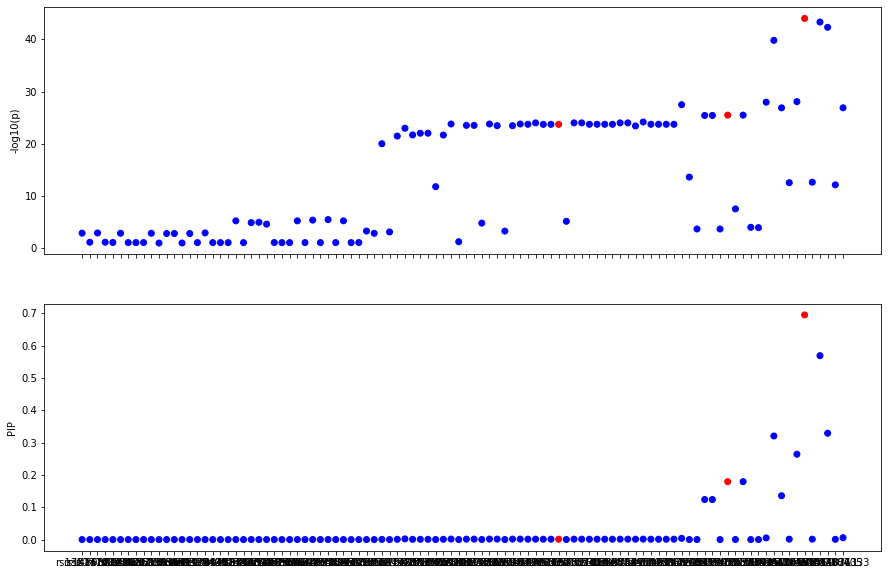

In [ ]:
PIP["val"] = PIP['SNP'].apply(lambda x: "red" if (x=='rs10104559' or 
                                                  x == 'rs1365732' or 
                                                  x == 'rs12676370') else "blue")
fig, axes = plt.subplots(nrows=2, sharex = True,figsize=(15, 10))
axes[0].scatter(x=PIP["SNP"], y=PIP["-log10(p)"], c=PIP["val"])
axes[1].scatter(x=PIP["SNP"], y=PIP["PIP"], c=PIP["val"])
axes[0].set(ylabel="-log10(p)")
axes[1].set(ylabel="PIP")
plt.show()

Output inferred PIP

In [ ]:
inferred_PIP.to_csv("COMP565_A2_SNP_pip.csv.gz")